# Imports

In [2]:
#%pip install transformers torch scikit-learn
#%pip install pyspellchecker
#%pip install wordcloud

import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import os
import pickle
from transformers import BertTokenizer, BertModel
from transformers import BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from wordcloud import WordCloud
from spellchecker import SpellChecker
from nltk.corpus import stopwords
from datetime import datetime
import re
from collections import Counter
import nltk
nltk.download('stopwords')  # This will download the stopwords dataset
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pedromiguel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load the pre-trained BERT model and tokenizer
print("\033[34mLoading Bert Tokenizer\n\033[0m")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print("\033[34mLoading Bert Model\n\033[0m")
model = BertModel.from_pretrained('bert-base-uncased')
print("\033[34mAll done!\n\033[0m")

Loading Bert Tokenizer

Loading Bert Model

All done!



In [4]:
# Reading the file and converting it to a DataFrame
def read_file_to_dataframe(filename):
    data = []
    
    with open("./data/" + filename, 'r', encoding='utf-8') as file:
        for linha in file:
            linha = linha.strip()  # Remove leading/trailing spaces and newlines
            filme = linha.split('\t')  # Split by tab
            data.append(filme)  # Append the row to the data list
    
    # Convert the list of rows to a pandas DataFrame
    df = pd.DataFrame(data)
    
    return df

# Variaveis onde está os ficheiros de treino e o modelo

In [5]:
#file onde já está o modelo treinado"
model=None
newPKL = "joao3"


#limpesa de ficheiro de treino
data="train"
#ficheiro onde vai ser feita ao autoavaliacao
avaliation = "test_no_labels"

In [6]:
print("\033[34mData to DataFrame\n\033[0m")
# Example usage
df = read_file_to_dataframe(data+".txt")
print(df)

Data to DataFrame

                              0          1        2                        3  \
0                  Ela Cheppanu     Telugu  romance                   Ramana   
1     A Nightmare on Elm Street   American   horror             Samuel Bayer   
2               American Gothic   American   horror               John Hough   
3                          Gang  Bollywood    crime              Mazhar Khan   
4            Intimate Relations    British    drama            Charles Frank   
...                         ...        ...      ...                      ...   
8036              Sa 'Yo Lamang   Filipino    drama          Laurice Guillen   
8037          The Lemon Sisters   American    drama             Joyce Chopra   
8038      Dil Ne Phir Yaad Kiya  Bollywood  romance                  Unknown   
8039  Rehnaa Hai Terre Dil Mein  Bollywood  romance            Gautham Menon   
8040             Things to Come    British   sci-fi  William Cameron Menzies   

                    

8041
Average word count: 370.33


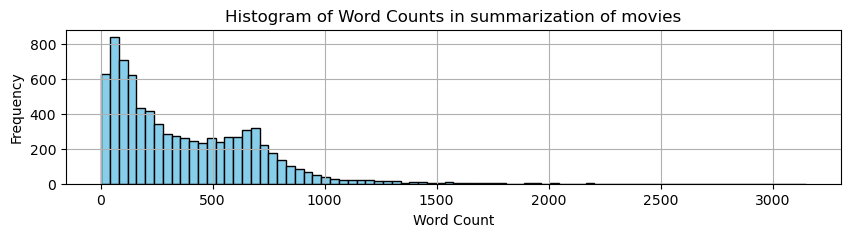

In [7]:
# histogram of word count
print(len(df))

df['word_count'] = df[4].apply(lambda x: len(x.split()))
avg_word_count = df['word_count'].mean()
print(f'Average word count: {avg_word_count:.2f}')
# Plotting the histogram of word counts
plt.figure(figsize=(10, 2))
plt.hist(df['word_count'], bins=80, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Counts in summarization of movies')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

the: 161014
to: 111607
and: 106034
a: 80092
of: 53504
is: 49072
his: 43843
in: 43811
he: 30869
that: 30744


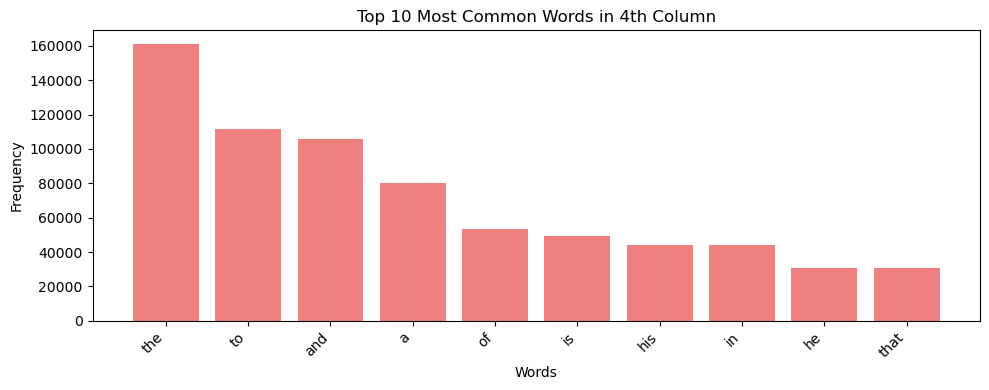

In [8]:
# Flatten all words from the 4th column into a single list
all_words = [word for row in df[4] for word in row.split()]

word_counter = Counter(all_words)

top_10_words = word_counter.most_common(10)

for word, count in top_10_words:
    print(f"{word}: {count}")

words, counts = zip(*top_10_words)

plt.figure(figsize=(10, 4))
plt.bar(words, counts, color='lightcoral')
plt.title('Top 10 Most Common Words in 4th Column')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate word labels for better readability
plt.tight_layout()
plt.show()

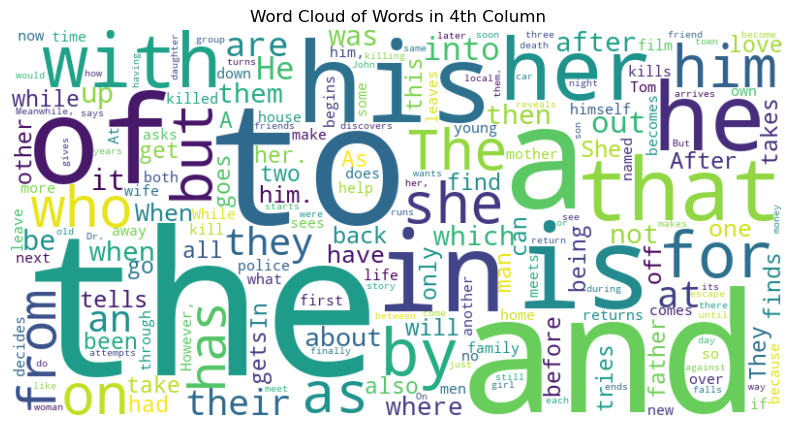

In [9]:
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud of Words in 4th Column')
plt.show()

In [10]:
# Check for typos using the pyspellchecker
spell = SpellChecker()
misspelled_words = spell.unknown(all_words)  # Identify misspelled words

# Display the number of potential typos
print(f"Number of potential typos: {len(misspelled_words)}")

# Optionally, print the misspelled words
print("\nPotential typos detected:")
for word in misspelled_words:
    print(word)

Number of potential typos: 110045

Potential typos detected:
parag
bystander,
submerge.
manifest.
cali's
cub,
vasanti
diggityland
pankin),
investments.
clemons).
despises,
rossi)
mayandi
maizie’s
american-born
(ellen
tish,
foxworth)
deeply.
fountain.
joan.
kildare),
stump,
colby's
etoile.
heywood
dee-dee
lago's
adoration.
them.[3]
reach,
drake),
edie,
gunboat,
mangan-lawrence),
trout’s
(brightening
firefight.
leng's
kun-bong
pickpockets.
toya
cheque,
conceive,
shop.
dern),
sellers)
8-year-old
avoy
niranj
t.'s
old-world
romulan
beatrix
watcher,
ranvir’s
seung-ho's
hentai
chungking,
tp
nuts}.
same/he's
police—the
toones),
tesla,
admonishment:
templetons,
jaffery),
saravana
charade,
mangos,
maniacally,
own,
rebooted.
madhabpur,
barris.
daphne's
minato
santorini,
d.e.b.;
ji's
epps's
holmes
1851,
vennila
belqassim.
shirts,
2023,
interest)
caszatt
£3
trifunović).
reitz
morrison's
olga,
steal,
kidnappers'
balakrishna),
bedford's
ocean;
kovu's
(dinah
townsville
aughra.
johnson)
harshman),
mars

## Pre Processamento

### Apenas precisa de  stop words, normalization e lower

In [11]:
# Function to standardize dates
def standardize_dates(text):
    def _month_to_number(month_name):
        try:
            return datetime.strptime(month_name, "%b").month  # Abbreviated month names (e.g., "Feb")
        except ValueError:
            try:
                return datetime.strptime(month_name, "%B").month  # Full month names (e.g., "February")
            except ValueError:
                return None  # Return None for invalid month names

    def _handle_two_digit_year(year):
        if not year:  # If year is None or empty
            return ""
        year = int(year)
        return year + 2000 if year < 100 else year

    # Date normalization using regex
    text = re.sub(
        r'(\b[A-Za-z]+) (\d{1,2})(?:st|nd|rd|th)?(?:,)? (\d{4})?',
        lambda match: (
            f"{int(match.group(2)):02d}/{_month_to_number(match.group(1)):02d}/{match.group(3)}"
            if _month_to_number(match.group(1)) is not None and match.group(3)  # Ensure month and year exist
            else f"{int(match.group(2)):02d}/{_month_to_number(match.group(1)):02d}"
            if _month_to_number(match.group(1)) is not None  # Ensure month exists
            else match.group(0)  # Return original text if invalid month
        ),
        text
    )

    # Handle formats like "8-Feb-2013"
    text = re.sub(
        r'(\d{1,2})(?:st|nd|rd|th)?[-/.](\b[A-Za-z]+)\b[-/.]?(\d{2,4})?',
        lambda match: (
            f"{int(match.group(1)):02d}/{_month_to_number(match.group(2)):02d}/{_handle_two_digit_year(match.group(3))}"
            if _month_to_number(match.group(2)) is not None and match.group(3)  # Ensure month and year exist
            else f"{int(match.group(1)):02d}/{_month_to_number(match.group(2)):02d}"
            if _month_to_number(match.group(2)) is not None  # Ensure month exists
            else match.group(0)  # Return original text if invalid month
        ),
        text
    )

    return text

In [12]:
# lowercasing
def lowercase_text(text):
    return text.lower()

In [13]:
# stop words
stop_words = set(stopwords.words('english'))
def remove_stopwords(text, stop_words=stop_words):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words and word.lower()]
    return " ".join(filtered_words)

In [14]:
def remove_references(text):
    # Substituir ".[\d]" por "."
    text = re.sub(r'\.\[\d+\]', '.', text)
    
    return text

In [15]:
print("\033[34mPre Processing the data\n\033[0m")
line_counter = 0

def preprocess_text(text):
    global line_counter
    print(f"Processing line {line_counter + 1}...")   # Print the line being processed
    line_counter += 1 
    text = standardize_dates(text)         # Step 1: Normalize dates
    text = lowercase_text(text)            # Step 2: Convert to lowercase
    text = remove_stopwords(text)          # Step 3: Remove stopwords
    text = remove_references(text)         # Step 4: Remove references
    
    return text

Pre Processing the data



In [16]:
df.iloc[:, 4] = df.iloc[:, 4].apply(preprocess_text)

print("\033[32mPre Processing Completed!\n\033[0m")

Processing line 1...
Processing line 2...
Processing line 3...
Processing line 4...
Processing line 5...
Processing line 6...
Processing line 7...
Processing line 8...
Processing line 9...
Processing line 10...
Processing line 11...
Processing line 12...
Processing line 13...
Processing line 14...
Processing line 15...
Processing line 16...
Processing line 17...
Processing line 18...
Processing line 19...
Processing line 20...
Processing line 21...
Processing line 22...
Processing line 23...
Processing line 24...
Processing line 25...
Processing line 26...
Processing line 27...
Processing line 28...
Processing line 29...
Processing line 30...
Processing line 31...
Processing line 32...
Processing line 33...
Processing line 34...
Processing line 35...
Processing line 36...
Processing line 37...
Processing line 38...
Processing line 39...
Processing line 40...
Processing line 41...
Processing line 42...
Processing line 43...
Processing line 44...
Processing line 45...
Processing line 46.

Processing line 602...
Processing line 603...
Processing line 604...
Processing line 605...
Processing line 606...
Processing line 607...
Processing line 608...
Processing line 609...
Processing line 610...
Processing line 611...
Processing line 612...
Processing line 613...
Processing line 614...
Processing line 615...
Processing line 616...
Processing line 617...
Processing line 618...
Processing line 619...
Processing line 620...
Processing line 621...
Processing line 622...
Processing line 623...
Processing line 624...
Processing line 625...
Processing line 626...
Processing line 627...
Processing line 628...
Processing line 629...
Processing line 630...
Processing line 631...
Processing line 632...
Processing line 633...
Processing line 634...
Processing line 635...
Processing line 636...
Processing line 637...
Processing line 638...
Processing line 639...
Processing line 640...
Processing line 641...
Processing line 642...
Processing line 643...
Processing line 644...
Processing 

## Carregar o modelo ou Criar um novo
#### Conforme o nome dado a variavel 'newPKL'

Average word count: 209.91


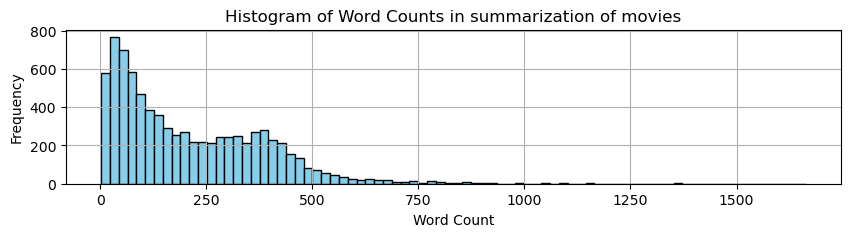

In [17]:
# histogram of word count after pre-processing
df['word_count'] = df[4].apply(lambda x: len(x.split()))
avg_word_count = df['word_count'].mean()
print(f'Average word count: {avg_word_count:.2f}')
# Plotting the histogram of word counts
plt.figure(figsize=(10, 2))
plt.hist(df['word_count'], bins=80, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Counts in summarization of movies')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

one: 6266
back: 4845
tells: 4558
him.: 4484
two: 4360
finds: 3770
get: 3767
find: 3724
also: 3619
new: 3358


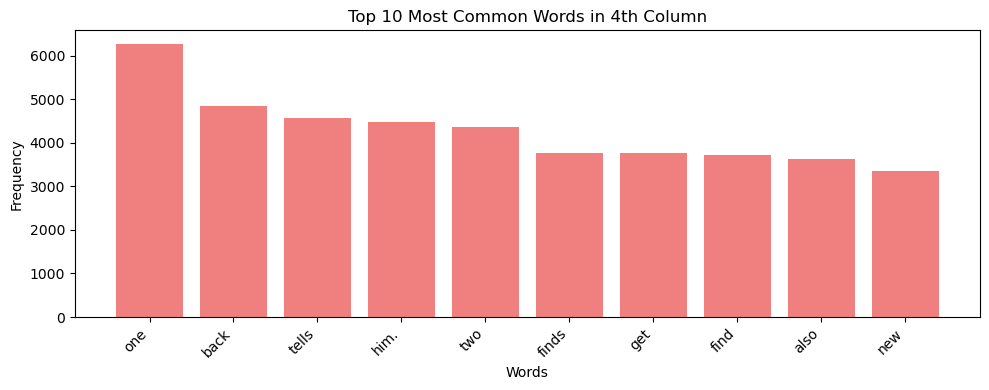

In [18]:
# Flatten all words from the 4th column into a single list after pre-processing
all_words = [word for row in df[4] for word in row.split()]

word_counter = Counter(all_words)

top_10_words = word_counter.most_common(10)

for word, count in top_10_words:
    print(f"{word}: {count}")

words, counts = zip(*top_10_words)

plt.figure(figsize=(10, 4))
plt.bar(words, counts, color='lightcoral')
plt.title('Top 10 Most Common Words in 4th Column')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate word labels for better readability
plt.tight_layout()
plt.show()

# Data after Pre Processing

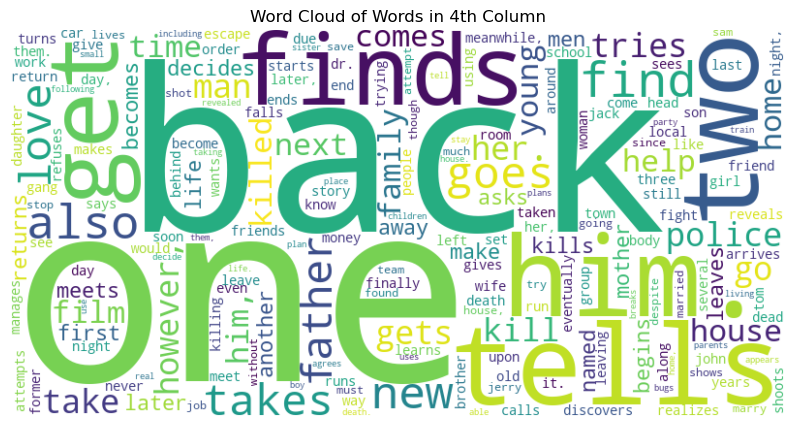

In [19]:
# Generate a word cloud after pre-processing
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud of Words in 4th Column')
plt.show()

## Carregar o modelo ou Criar um novo
#### Conforme o nome dado a variavel 'newPKL'

In [23]:
def prepare_data(texts, tokenizer, max_length=512):
    inputs = tokenizer(
        texts,
        return_tensors="pt",  # Return PyTorch tensors
        truncation=True,  # Truncate if text exceeds max length
        padding=True,     # Pad to the same length
        max_length=max_length  # Maximum length of tokens
    )
    return inputs['input_ids'], inputs['attention_mask']

In [29]:
if os.path.isfile("data/bert_model1.pkl"):
    print("\033[34mLoading Model\n\033[0m")
    with open('data/svm_model1.pkl', 'rb') as f:
        clf, tfidf_vectorizer = pickle.load(f)
else:
    # Convert all entries in df[4] to strings
    texts = df[4].astype(str).tolist() 

    # Prepare input ids and attention mask from df[4]
    input_ids, attention_mask = prepare_data(texts, tokenizer)
    labels = torch.tensor(df[2])  # Convert labels (df[2]) to PyTorch tensor
    # Load BERT with a classification head (number of labels: 2 for binary classification)
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

    # Define optimizer
    optimizer = AdamW(model.parameters(), lr=1e-5)  # Very small learning rate
    
    # Create a Dataset object
    dataset = TensorDataset(input_ids, attention_mask, labels)

    # Split into training and testing sets
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=16)

    # Set device to GPU if available
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)

    # Training loop
    for epoch in range(3):  # Fine-tune for 3 epochs
        model.train()  # Set model to training mode
        
        total_loss = 0
        for batch in train_dataloader:
            # Unpack batch and move to device
            b_input_ids, b_attention_mask, b_labels = [x.to(device) for x in batch]
            
            # Reset gradients
            model.zero_grad()
            
            # Forward pass
            outputs = model(
                input_ids=b_input_ids,
                attention_mask=b_attention_mask,
                labels=b_labels
            )
            loss = outputs.loss
            total_loss += loss.item()
            
            # Backward pass
            loss.backward()
            
            # Optimize
            optimizer.step()

        # Print training loss per epoch
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_dataloader)}')

    print("Training complete!")

ValueError: too many dimensions 'str'

# Evaluate the Model

In [ ]:
model.eval()  # Set model to evaluation mode

predictions, true_labels = [], []

with torch.no_grad():
    for batch in test_dataloader:
        b_input_ids, b_attention_mask, b_labels = [x.to(device) for x in batch]
        
        outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits
        
        # Move logits and labels to CPU for evaluation
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Store predictions and true labels
        predictions.append(np.argmax(logits, axis=1))
        true_labels.append(label_ids)

# Flatten the predictions and true labels
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')